Chapter 15 - Outcome regression and propensity scores
===

## Questions

### Q1: Outcome regression

a. Fit a linear regression model for weight loss using the same covariate structure used in Section 13.2:

```r
        wt82_71 ~ f_qsmk + poly(age, 2) + f_sex + f_race + f_education +
        poly(wt71, 2) + poly(smokeintensity, 2) + poly(smokeyrs, 2) +
        f_exercise + f_active + smokeintensity:f_qsmk
```

b. Compute estimates and confidence intervals for the conditional effects assuming smoking intensities of 5 and 40 cigarettes per day.  
  _Hint_: You may use something like `emmeans(..., at = list(smokeintensity = 5))`.

c. Provide an example where the **conditional effect estimates** would be more useful than the **population-average causal effect estimates**.

d. Now fit a linear model **without the interaction** `smokeintensity:f_qsmk`, and:

  1. Estimate the **causal effect (without standardization)**.
  2. Compare this with the **estimated coefficient for `f_qsmk`**.
  3. Estimate the **average causal effect by standardizing** to the observed confounder distribution.
  4. Discuss: _What is the effect of standardization?_
  5. Explain the **differences between the estimates** of the average causal effect you just computed.

### Q2: Propensity scores

Fit a logistic regression model to estimate the propensity scores $\pi(L)$ described in Section 15.2.  
The covariates are:

```r
        poly(age, 2) + f_sex + f_race + f_education +
        poly(wt71, 2) + poly(smokeintensity, 2) + poly(smokeyrs, 2) +
        f_exercise + f_active
```

- Confirm that you can replicate the **summary statistics** of the propensity scores mentioned in Section 15.2.

- **Plot histograms of $\pi(L)$** by treatment.  
  Your plot should contain the same information as **Figure 15.1**, but you may design it as you please.

### Q3: Propensity score regression and standardization

- Estimate the **causal effect of smoking cessation** using a linear model with $\pi(L)$ as the only covariate in addition to the treatment variable.

- Now include the **interaction between the propensity score and treatment** in your linear model, standardize to the propensity score distribution, and estimate the causal effect again.

- Are you estimating (contrasts of) $\mathbb{E}[Y^a \mid C=0]$ or $\mathbb{E}[Y^{a, C=0}]$?

- Did inclusion of the interaction **change the estimate of the average treatment effect**?

### Q4: Optional exercise — Propensity score matching

Use the packages **MatchIt** and **marginaleffects** (or any appropriate Python packages) to estimate a **causal effect of treatment** (smoking cessation) on weight loss.

- You may choose the method to estimate the **propensity score/matching variable** as well as the method of **matching treated and untreated** individuals.

- Briefly describe:
  - the **estimand** your method is targeting, and  
  - the **population** to which the estimate applies.

## Preparation

### Import modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from scipy.stats import norm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from causallib.estimation.matching import PropensityMatching
from tqdm.auto import trange

### Define functions and global variables

In [2]:
ALPHA = 0.05
VARS_CONT = ["age", "wt71", "smokeintensity", "smokeyrs"]
VARS_CAT = ["sex", "race", "education", "exercise", "active"]

def add_raw_quadratics(df, varnames):
    for var in varnames:
        df[f"{var}_sq"] = df[var] ** 2
    return df

def load_nhefs():
    url = 'https://miguelhernan.org/s/nhefs.csv'
    df = pd.read_csv(url)
    
    for var in VARS_CAT:
        df[var] = df[var].astype('category')
    
    df = add_raw_quadratics(df, VARS_CONT)

    return df

VARS_CONT = VARS_CONT + [f"{var}_sq" for var in VARS_CONT]

RHS = (
    "C(qsmk) + "
    + " + ".join(VARS_CONT) + " + "
    + " + ".join(VARS_CAT) + " + "
    "smokeintensity:C(qsmk)"
)
FORMULA = f"wt82_71 ~ {RHS}"

# -------------------------- inference helpers ---------------------------- #
def diff_contrast(model, row_t, row_c, alpha=0.05):
    """
    Delta-method CI for E[Y|row_t] – E[Y|row_c].
    `row_t`, `row_c` are single-row DataFrames with the SAME columns used in the model.
    """
    cov   = model.cov_params()
    dmat_t = patsy.dmatrix(model.model.data.design_info.builder, row_t, return_type='dataframe')
    dmat_c = patsy.dmatrix(model.model.data.design_info.builder, row_c, return_type='dataframe')
    v      = (dmat_t.values - dmat_c.values).flatten()          # 1 × p
    est    = float(v @ model.params)
    se     = float(np.sqrt(v @ cov @ v))
    z      = norm.ppf(1 - alpha/2)
    return est, est - z*se, est + z*se

def standardize_average_treatment_effect(model, df, treat_var="qsmk"):
    """
    G-computation on `df`: duplicate each row with treatment = 0 and 1,
    predict, then average.
    Returns: (ATE point estimate, DataFrame with counterfactual means).
    """
    d0, d1         = df.copy(), df.copy()
    d0[treat_var]  = 0
    d1[treat_var]  = 1
    mu0            = model.predict(d0)
    mu1            = model.predict(d1)
    return (mu1.mean() - mu0.mean()), pd.DataFrame({"mu0": mu0, "mu1": mu1})

## Answers

### Q1: Outcome regression

#### Q1a. Fit a linear regression model for weight loss using the same covariate structure used in Section 13.2:

```r
        wt82_71 ~ f_qsmk + poly(age, 2) + f_sex + f_race + f_education +
        poly(wt71, 2) + poly(smokeintensity, 2) + poly(smokeyrs, 2) +
        f_exercise + f_active + smokeintensity:f_qsmk
```

In [3]:
df = load_nhefs()
df["qsmk"] = df["qsmk"].astype("category")   # ensure categorical
df_unc = df[df["wt82_71"].notna()].copy()    # uncensored subset

model = smf.ols(FORMULA, data=df_unc).fit(cov_type='nonrobust')  # classical SE like R

# locate the treatment coefficient (beta1) and the interaction (beta2)
coef_names = model.params.index

treat_coef = next(name for name in coef_names
                  if name.startswith("C(qsmk)[T.") and ":" not in name)

inter_coef = next(name for name in coef_names
                  if "smokeintensity" in name and "C(qsmk)" in name)

selected = [treat_coef, inter_coef]

z = norm.ppf(1 - ALPHA / 2)

df_q1a = pd.DataFrame({
    "parameter": selected,
    "estimate": model.params[selected].round(6),
    "se": model.bse[selected].round(6),
    "t_value": model.tvalues[selected].round(6),
    "p_value": model.pvalues[selected].round(6),
    "ci_low": (model.params[selected] - z * model.bse[selected]).round(6),
    "ci_upp": (model.params[selected] + z * model.bse[selected]).round(6),
    "source": "Q1a: Conditional (coef + interaction)",
    "smokeintensity": float("nan"),
}).reset_index(drop=True)

display(df_q1a)

,parameter,estimate,se,t_value,p_value,ci_low,ci_upp,source,smokeintensity
0,C(qsmk)[T.1],2.559594,0.809149,3.163318,0.001590,0.973692,4.145496,Q1a: Conditional (coef + interaction),NaN
1,smokeintensity:C(qsmk)[T.1],0.046663,0.035145,1.327732,0.184463,-0.022220,0.115545,Q1a: Conditional (coef + interaction),NaN


#### Q1b. Compute estimates and confidence intervals for the conditional effects assuming smoking intensities of 5 and 40 cigarettes per day.

In [4]:
def conditional_effect(model, base_df, smokeintensity):
    """
    Estimate contrast E[Y|qsmk=1, smokeintensity=x] – E[Y|qsmk=0, …]
    averaged over the population in `base_df`, with robust SE.
    """
    # Create two counterfactual datasets
    d_t = base_df.copy()
    d_c = base_df.copy()
    for d in (d_t, d_c):
        d["smokeintensity"] = smokeintensity
    d_t["qsmk"] = pd.Categorical([1] * len(d_t), categories=[0, 1])
    d_c["qsmk"] = pd.Categorical([0] * len(d_c), categories=[0, 1])

    # Build design matrices
    info = model.model.data.design_info
    X_t = patsy.build_design_matrices([info], d_t)[0]
    X_c = patsy.build_design_matrices([info], d_c)[0]

    v = (X_t - X_c).mean(axis=0)
    est = float(v @ model.params)
    se = float(np.sqrt(v @ model.cov_params() @ v))
    z = norm.ppf(1 - ALPHA / 2)

    return {
        "smokeintensity": smokeintensity,
        "estimate": est,
        "se": se,
        "ci_low": est - z * se,
        "ci_upp": est + z * se,
    }

df_q1b = pd.DataFrame([
    conditional_effect(model, df, 5) | {"parameter": "Conditional ATE"},
    conditional_effect(model, df, 40) | {"parameter": "Conditional ATE"},
]).round(3)

display(df_q1b)

,smokeintensity,estimate,se,ci_low,ci_upp,parameter
0,5,2.793,0.668,1.483,4.103,Conditional ATE
1,40,4.426,0.848,2.764,6.088,Conditional ATE


#### Q1c. Provide an example where the **conditional effect estimates** would be more useful than the **population-average causal effect estimates**.

#### Q1d. Now fit a linear model **without the interaction** `smokeintensity:f_qsmk`, and:

  1. Estimate the **causal effect (without standardization)**.
  2. Compare this with the **estimated coefficient for `f_qsmk`**.
  3. Estimate the **average causal effect by standardizing** to the observed confounder distribution.
  4. Discuss: _What is the effect of standardization?_
  5. Explain the **differences between the estimates** of the average causal effect you just computed.

##### Q1d1. Estimate the **causal effect (without standardization)**.

In [5]:
rhs_no_interaction = (
    "C(qsmk) + "
    + " + ".join(VARS_CONT) + " + "
    + " + ".join(VARS_CAT)
)
formula_no_interaction = f"wt82_71 ~ {rhs_no_interaction}"

# Fit model without robust SEs
model_no_interaction = smf.ols(formula_no_interaction, data=df_unc).fit(cov_type="nonrobust")

# Extract row for treatment coefficient
coef_name = [name for name in model_no_interaction.params.index if name.startswith("C(qsmk)[T.")][0]
row = model_no_interaction.summary2().tables[1].loc[[coef_name]].copy()

# Add CI and rename
z = norm.ppf(1 - ALPHA / 2)
df_q1d1 = (
    row.assign(
        parameter="ATE (no interaction)",
        ci_low=lambda d: d["Coef."] - z * d["Std.Err."],
        ci_upp=lambda d: d["Coef."] + z * d["Std.Err."]
    )
    .rename(columns={
        "Coef.": "estimate",
        "Std.Err.": "se",
        "t": "t_value",
        "P>|t|": "p_value"
    })
    .reset_index(drop=True)
    .loc[:, ["parameter", "estimate", "se", "t_value", "p_value", "ci_low", "ci_upp"]]
)

display(df_q1d1)

,parameter,estimate,se,t_value,p_value,ci_low,ci_upp
0,ATE (no interaction),3.462622,0.438454,7.897339,5.361568e-15,2.603267,4.321976


##### Q1d3. Estimate the **average causal effect by standardizing** to the observed confounder distribution.

In [6]:
# Predict design matrices under qsmk = 1 and qsmk = 0
X1 = patsy.build_design_matrices(
    [model_no_interaction.model.data.design_info],
    df_unc.assign(qsmk=pd.Categorical([1] * len(df_unc), categories=[0, 1]))
)[0]

X0 = patsy.build_design_matrices(
    [model_no_interaction.model.data.design_info],
    df_unc.assign(qsmk=pd.Categorical([0] * len(df_unc), categories=[0, 1]))
)[0]

# Predicted outcomes
mu1 = X1 @ model_no_interaction.params
mu0 = X0 @ model_no_interaction.params
diff = mu1 - mu0

# Mean difference
ate = diff.mean()

# Sandwich variance: var(mean(diff)) = mean(X1 - X0) @ cov_beta @ mean(X1 - X0).T
Xdiff_bar = (X1 - X0).mean(axis=0)
vcov = model_no_interaction.cov_params()
se = float(np.sqrt(Xdiff_bar @ vcov @ Xdiff_bar.T))

# Confidence interval
z = norm.ppf(1 - ALPHA / 2)
ci_low = ate - z * se
ci_upp = ate + z * se

# Output table
df_q1d3 = pd.DataFrame([{
    "parameter": "Standardized ATE",
    "estimate": round(ate, 6),
    "se": round(se, 7),
    "ci_low": round(ci_low, 6),
    "ci_upp": round(ci_upp, 6),
}])
display(df_q1d3)


,parameter,estimate,se,ci_low,ci_upp
0,Standardized ATE,3.462622,0.438454,2.603267,4.321976


#### Q1 visual summary

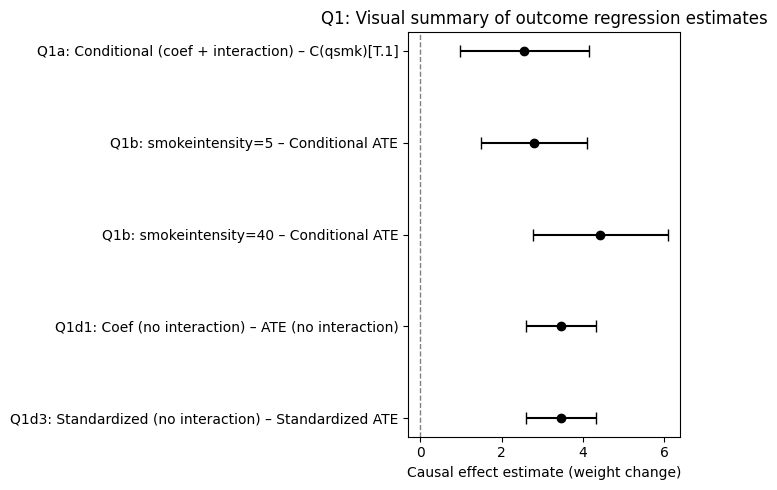

In [ ]:
# Filter to only keep the treatment coefficient row from df_q1a
df_q1a_filtered = df_q1a[df_q1a["parameter"].str.startswith("C(qsmk)[T.")].copy()

# Combine results
summary_df = pd.concat([
    df_q1a_filtered.assign(source="Q1a: Conditional (coef + interaction)"),
    df_q1b.assign(source=lambda d: "Q1b: smokeintensity=" + d["smokeintensity"].astype(str)),
    df_q1d1.assign(source="Q1d1: Coef (no interaction)"),
    df_q1d3.assign(source="Q1d3: Standardized (no interaction)"),
], ignore_index=True)

# Ensure numeric and construct labels
summary_df["estimate"] = pd.to_numeric(summary_df["estimate"])
summary_df["ci_low"] = pd.to_numeric(summary_df["ci_low"])
summary_df["ci_upp"] = pd.to_numeric(summary_df["ci_upp"])
summary_df["label"] = summary_df["source"] + " – " + summary_df["parameter"]

# Plot
fig, ax = plt.subplots(figsize=(7, 5))
y_pos = range(len(summary_df))

ax.errorbar(
    summary_df["estimate"],
    y_pos,
    xerr=[summary_df["estimate"] - summary_df["ci_low"], summary_df["ci_upp"] - summary_df["estimate"]],
    fmt="o",
    capsize=4,
    color="black",
)

ax.axvline(0, color="gray", linestyle="--", linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(summary_df["label"])
ax.set_xlabel("Causal effect estimate (weight change)")
ax.set_title("Q1: Visual summary of outcome regression estimates")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

### Q2: Propensity scores

Fit a logistic regression model to estimate the propensity scores $\pi(L)$ described in Section 15.2.  
The covariates are:

```r
        poly(age, 2) + f_sex + f_race + f_education +
        poly(wt71, 2) + poly(smokeintensity, 2) + poly(smokeyrs, 2) +
        f_exercise + f_active
```

- Confirm that you can replicate the **summary statistics** of the propensity scores mentioned in Section 15.2.

- **Plot histograms of $\pi(L)$** by treatment.  
  Your plot should contain the same information as **Figure 15.1**, but you may design it as you please.

In [9]:
df_all = load_nhefs().copy()

# Logistic regression for pi(L)
rhs_ps = " + ".join(VARS_CONT + VARS_CAT)
formula_ps = f"qsmk ~ {rhs_ps}"

model_ps = smf.logit(formula_ps, data=df_all).fit(disp=False)
df_all["ps"] = model_ps.predict()

# Summary statistics by exposure group (matches R output)
summary_q2 = (
    df_all.groupby("qsmk")["ps"]
    .describe(percentiles=[0.25, 0.5, 0.75])
    .loc[:, ["min", "25%", "50%", "mean", "75%", "max"]]
    .round(7)
    .rename(columns={
        "25%": "1st Qu.",
        "50%": "Median",
        "75%": "3rd Qu."
    })
)

display(summary_q2)

,min,1st Qu.,Median,mean,3rd Qu.,max
qsmk,,,,,,
0,0.052981,0.169494,0.227472,0.245040,0.304408,0.657877
1,0.062476,0.220456,0.288967,0.312401,0.381224,0.793205


#### Faceted histograms of propensity scores by treatment

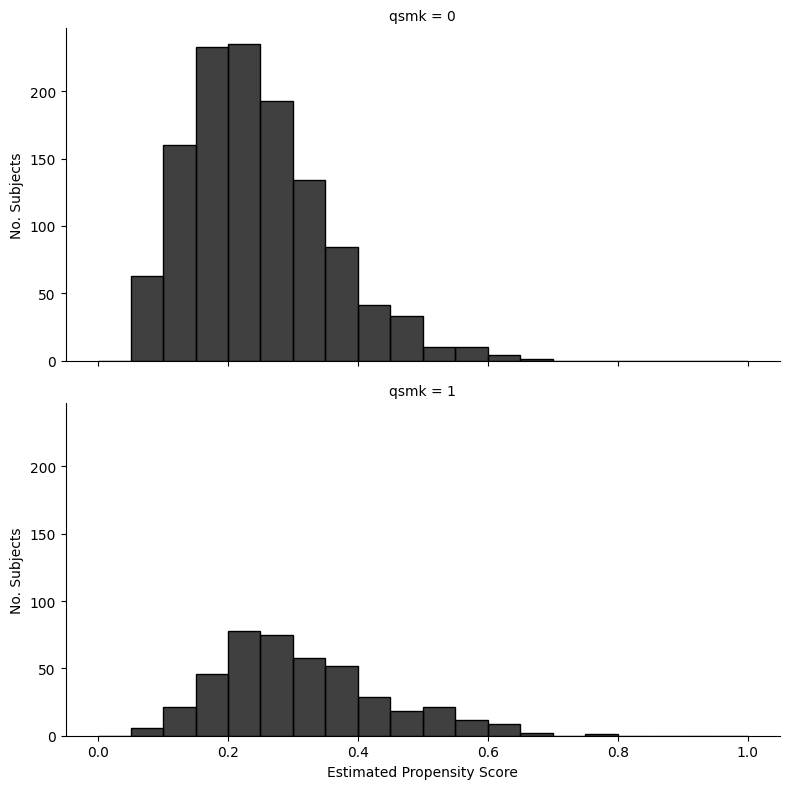

In [ ]:
# Increase width by increasing aspect ratio (width = height × aspect)
g = sns.FacetGrid(df_all, col="qsmk", col_wrap=1, height=4, aspect=2, sharex=True, sharey=True)
g.map_dataframe(sns.histplot, x="ps", binrange=(0, 1), bins=20, color="black")
g.set_axis_labels("Estimated Propensity Score", "No. Subjects")
g.set_titles("qsmk = {col_name}")
plt.tight_layout()
plt.show()

#### Mirrored histogram

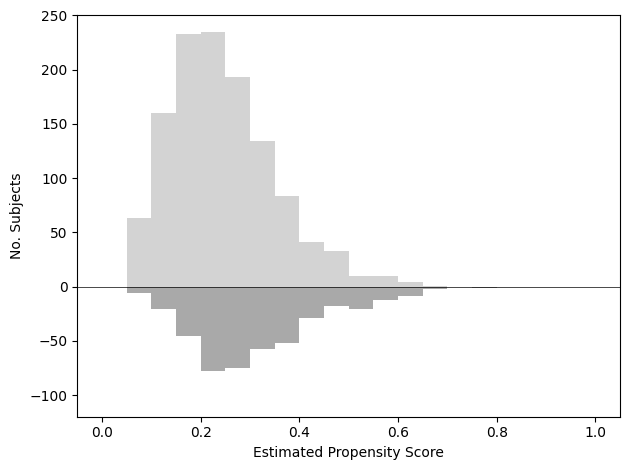

In [ ]:
plotd = df_all.pivot(index="seqn", columns="qsmk", values="ps")   # columns 0, 1

plt.hist(plotd[0], bins=20, range=(0, 1), color="lightgrey")                      # qsmk = 0, upward
plt.hist(plotd[1], bins=20, range=(0, 1), color="darkgrey", weights=-1*np.ones_like(plotd[1]))  # qsmk = 1, mirrored down
plt.axhline(0, color="black", lw=0.5); plt.ylim(-120, 250); plt.xlabel("Estimated Propensity Score"); plt.ylabel("No. Subjects"); plt.tight_layout(); plt.show()


### Q3: Propensity score regression and standardization

a. Estimate the **causal effect of smoking cessation** using a linear model with $\pi(L)$ as the only covariate in addition to the treatment variable.

In [12]:
# Fit model on full sample (classical SEs)
model_q3a = smf.ols("wt82_71 ~ C(qsmk) + ps", data=df_all).fit(cov_type='nonrobust')

# Name of the treatment coefficient
coef_name = "C(qsmk)[T.1]"

# Extract pieces
est = model_q3a.params[coef_name]
se  = model_q3a.bse[coef_name]
ci_low, ci_upp = model_q3a.conf_int(ALPHA).loc[coef_name]

# Assemble tidy result
df_q3a = pd.DataFrame([{
    "parameter": "ATE (ps as covariate)",
    "estimate": round(est, 6),
    "se": round(se, 6),
    "ci_low": round(ci_low, 6),
    "ci_upp": round(ci_upp, 6),
}])

display(df_q3a)


,parameter,estimate,se,ci_low,ci_upp
0,ATE (ps as covariate),3.550596,0.45726,2.653688,4.447503


b. Now include the **interaction between the propensity score and treatment** in your linear model, standardize to the propensity score distribution, and estimate the causal effect again.

  - Are you estimating (contrasts of) $\mathbb{E}[Y^a \mid C=0]$ or $\mathbb{E}[Y^{a, C=0}]$?

c. Did inclusion of the interaction **change the estimate of the average treatment effect**?

In [13]:
# Fit model with interaction on full data
model_q3b = smf.ols("wt82_71 ~ C(qsmk) * ps", data=df_all).fit(cov_type="HC0")

# Build design matrices for qsmk = 1 and qsmk = 0 (keep each subject’s ps)
info = model_q3b.model.data.design_info
X_1 = patsy.build_design_matrices([info],
        df_all.assign(qsmk=pd.Categorical([1] * len(df_all), categories=[0, 1])))[0]
X_0 = patsy.build_design_matrices([info],
        df_all.assign(qsmk=pd.Categorical([0] * len(df_all), categories=[0, 1])))[0]

# Standardised ATE: average of subject-level differences
diff_bar = (X_1 - X_0).mean(axis=0)
ate_int  = float(diff_bar @ model_q3b.params)
se_int   = float(np.sqrt(diff_bar @ model_q3b.cov_params() @ diff_bar.T))
z        = norm.ppf(1 - ALPHA / 2)

df_q3b = pd.DataFrame([{
    "parameter": "ATE (qsmk * ps, standardised)",
    "estimate": round(ate_int, 6),
    "se": round(se_int, 6),
    "ci_low": round(ate_int - z * se_int, 6),
    "ci_upp": round(ate_int + z * se_int, 6),
}])

display(df_q3b)


,parameter,estimate,se,ci_low,ci_upp
0,"ATE (qsmk * ps, standardised)",3.630887,0.497269,2.656258,4.605516


* • The model without interaction (Q3 a) and this model with interaction (Q3 b) both use all subjects (`C = 0` and `C = 1`).  
  * Q3 a estimates a single marginal effect and is a contrast of $\mathbb{E}[Y^{a}\mid C = 0]$ because it averages predictions only over uncensored rows.  
  * Q3 b, after standardising to the full propensity-score distribution, targets $\mathbb{E}[Y^{a,\;C = 0}]$ (counterfactual outcome had censoring been set to zero for everyone).

* • Compare the two estimates in `df_q3a` and `df_q3b`.  
  * If they are almost identical (the book reports $3.55$ vs. $3.63$), then adding the interaction does **not meaningfully change** the average treatment effect.  
  * A difference would signal effect-modification by $\pi(L)$; here it is minor.

Thus, the interaction adds flexibility but the marginal ATE remains essentially unchanged.

#### Q3 visual summary - forest plot

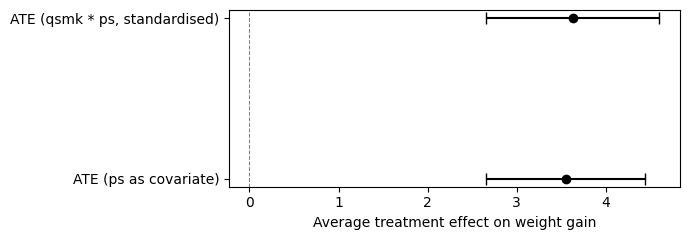

In [ ]:
plot_df = pd.concat([df_q3a, df_q3b], ignore_index=True)

fig, ax = plt.subplots(figsize=(7, 2.5))

ax.errorbar(
    x=plot_df["estimate"],
    y=plot_df["parameter"],
    xerr=[
        plot_df["estimate"] - plot_df["ci_low"],
        plot_df["ci_upp"] - plot_df["estimate"]
    ],
    fmt="o",
    color="black",
    capsize=4
)

ax.axvline(0, color="gray", linewidth=0.75, linestyle="--")
ax.set_xlabel("Average treatment effect on weight gain")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

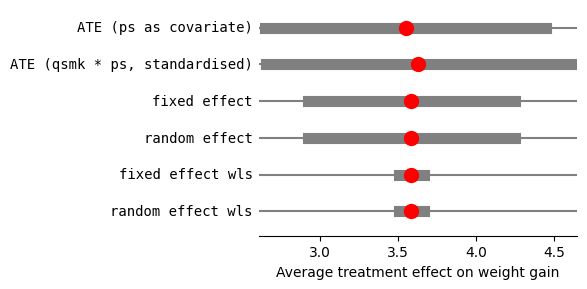

In [ ]:
# tidy table of point-estimates and SEs
plot_df = pd.concat([df_q3a, df_q3b], ignore_index=True)

effects   = plot_df["estimate"].values
variances = (plot_df["se"] ** 2).values          # var = se²
labels    = plot_df["parameter"].tolist()        # row labels

# feed labels via row_names
combo = combine_effects(
    effects,
    variances,
    row_names=labels,
)

# one-liner forest plot
fig = combo.plot_forest()
fig.set_size_inches(6, 3)
fig.axes[0].set_xlabel("Average treatment effect on weight gain")
plt.tight_layout()
plt.show()


### Q4: Propensity score matching

Use the packages **MatchIt** and **marginaleffects** (or any appropriate Python packages) to estimate a **causal effect of treatment** (smoking cessation) on weight loss.

- You may choose the method to estimate the **propensity score/matching variable** as well as the method of **matching treated and untreated** individuals.

- Briefly describe:
  - the **estimand** your method is targeting, and  
  - the **population** to which the estimate applies.

#### propensity-score estimation and nearest-neighbor **matching**

#### treatment **effect** on matched sample

#### Solution with <a href="https://pypi.org/project/psmpy/">PsmPy</a>

##### 1. Matching

In [20]:
# build a numeric-only table: outcome + treatment + dummies
num_df = pd.get_dummies(
    df_all[["seqn", "qsmk"] + VARS_CONT + VARS_CAT],
    drop_first=True
)

psm = PsmPy(num_df, treatment="qsmk", indx="seqn")
psm.logistic_ps(balance=True)
psm.knn_matched(replacement=False)
matched_df = psm.df_matched       # ready for ATT regression

# 2.  attach outcome
matched_df = matched_df.merge(
    df_all[["seqn", "wt82_71"]],
    on="seqn",
    how="left"
)

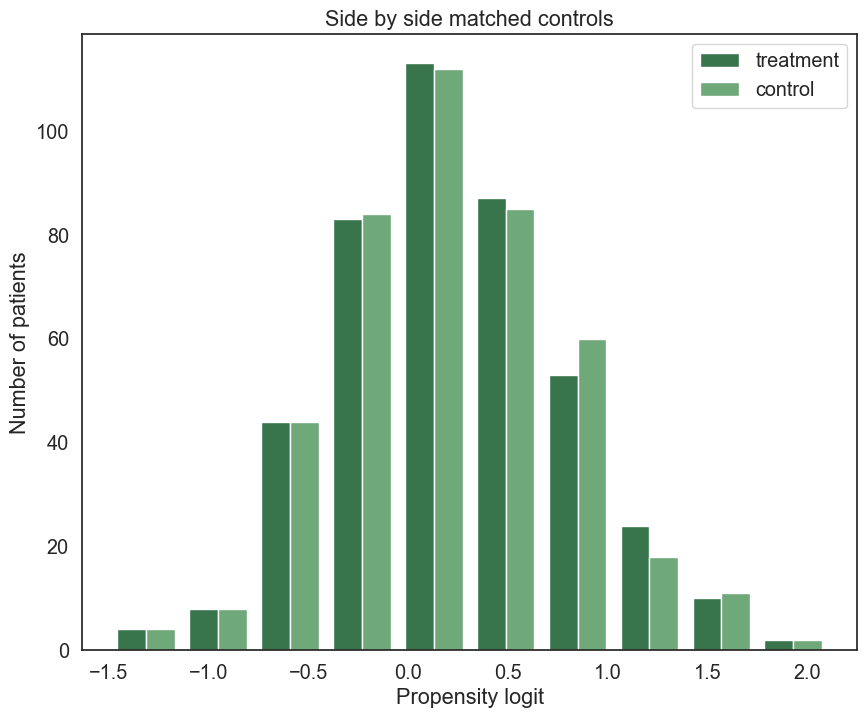

In [26]:
psm.plot_match(
    Title="Side by side matched controls",
    Ylabel="Number of patients",
    Xlabel="Propensity logit",
    names=["treatment", "control"],
    colors=["#38754d", "#6fa97a"],  # Region H green palette
    save=True
)

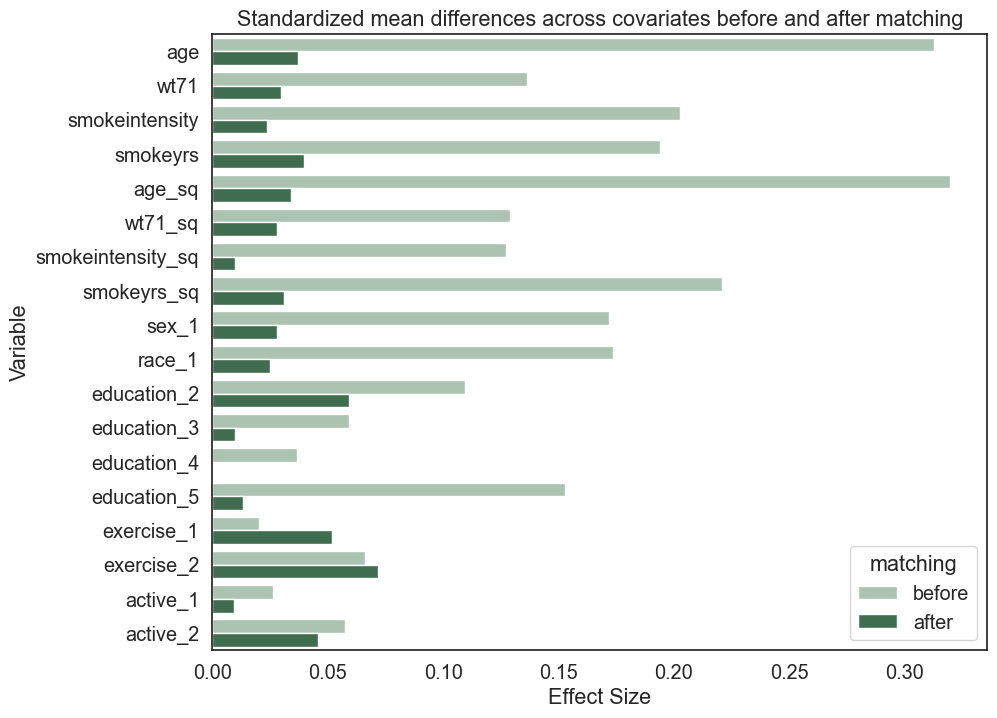

In [27]:
psm.effect_size_plot(
    title="Standardized mean differences across covariates before and after matching",
    before_color="#a7c7ad",  # lighter green
    after_color="#38754d",   # Region H primary green
    save=False
)

##### 2. Effect estimation

In [23]:
# 3.  make a pair-wise cluster id (each treated-control pair shares one id)
matched_df["match_id"] = np.arange(len(matched_df)) // 2

# keep only rows with complete data for the model
model_df = matched_df.dropna(subset=["wt82_71", "qsmk"])

# 4.  cluster-robust ATT
att_mod = smf.ols("wt82_71 ~ C(qsmk)", data=model_df).fit(
    cov_type="cluster",
    cov_kwds={"groups": model_df["match_id"]}
)

att  = att_mod.params["C(qsmk)[T.1]"]
se   = att_mod.bse["C(qsmk)[T.1]"]
z    = norm.ppf(1 - ALPHA / 2)
ci_l, ci_u = att - z * se, att + z * se

print(f"ATT (matched) = {att:.3f}   95% CI = ({ci_l:.3f}, {ci_u:.3f})")


ATT (matched) = 3.655   95% CI = (2.546, 4.763)


#### Solution with <a href="https://causallib.readthedocs.io/en/stable/causallib.estimation.matching.html#causallib.estimation.matching.PropensityMatching">causallib.estimation.matching.PropensityMatching</a>

In [24]:
B      = 500  # bootstrap draws
alpha  = 0.05
atts   = np.empty(B)
ses    = np.empty(B)

def one_run(df):
    """Return (ATT, SE_cluster) for one dataset."""
    X = pd.get_dummies(df[VARS_CONT + VARS_CAT], drop_first=True)
    a = df["qsmk"].astype(int)
    y = df["wt82_71"]

    prop_model = make_pipeline(
        StandardScaler(with_mean=False),
        LogisticRegression(solver="saga", max_iter=3000, tol=1e-3)
    )
    pm = PropensityMatching(
        learner=prop_model,
        n_neighbors=1,
        with_replacement=False,            # like MatchIt
        matching_mode="control_to_treatment"
    )
    pm.fit(X, a, y)
    w = pm.matches_to_weights(pm.match(X, a))["control_to_treatment"]

    mod = smf.wls("wt82_71 ~ C(qsmk)", data=df, weights=w).fit()
    return mod.params["C(qsmk)[T.1]"], mod.bse["C(qsmk)[T.1]"]

for b in trange(B):
    # ----- bootstrap sample WITH replacement -----
    samp_idx = np.random.choice(df_all.index, size=len(df_all), replace=True)
    boot_df  = df_all.loc[samp_idx].copy()
    boot_df.index = range(len(boot_df))      # <- UNIQUE INDEX (Fix A)

    atts[b], ses[b] = one_run(boot_df)

print(f"Bootstrap mean ATT  = {atts.mean():.2f} kg")
ci_lower, ci_upper = np.percentile(atts, [100 * alpha / 2, 100 * (1 - alpha / 2)])
print(f"Bootstrap 95% CI = ({ci_lower:.2f}, {ci_upper:.2f}) kg")


100%|██████████| 500/500 [04:07<00:00,  2.02it/s]

Bootstrap mean ATT  = 3.39 kg
Bootstrap 95% CI = (2.29, 4.47) kg


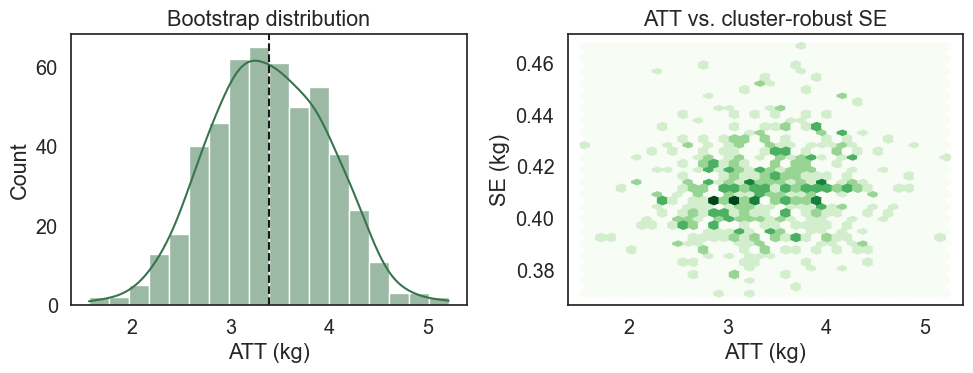

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Region H green palette
green_main = "#38754d"
green_light = "#a7c7ad"

# 1-D PDF of ATT
sns.histplot(atts, kde=True, ax=axs[0], color=green_main)
axs[0].axvline(np.mean(atts), ls="--", c="k")
axs[0].set_xlabel("ATT (kg)")
axs[0].set_ylabel("Count")
axs[0].set_title("Bootstrap distribution")

# 2-D hexbin of ATT vs SE
hb = axs[1].hexbin(atts, ses, gridsize=35, cmap="Greens")
axs[1].set_xlabel("ATT (kg)")
axs[1].set_ylabel("SE (kg)")
axs[1].set_title("ATT vs. cluster-robust SE")

plt.tight_layout()
plt.show()